In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /home/allworder/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import torch

Будем использовать NDCG метрику для оценки качества модели

In [4]:
from sklearn.metrics import ndcg_score

Меткрики близости веторов:

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
import vector_space_models_utils
from vector_space_models_utils import rank_comments

Загрузка предобработанного датасета:

In [7]:
train_df = pd.read_table('ranking_train.tsv')

In [8]:
import string

In [9]:
from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))

# Word2vec and GloVe pretrained models vectorization

В данном разделе для перевода текстов комментариев и поста в вектора мы будем использовать уже предобученные embedding Word2vec или GloVe.

In [10]:
import gensim.downloader

Загрузим модель:

In [8]:
glove_embeddings = gensim.downloader.load('glove-wiki-gigaword-50')
glove_vectors_dim = 50

Создадим токенизатор с небольшой предобработкой текста:

In [14]:
class NLTK_Tokenizer:
    def __init__(self, delete_punctuation=False, delete_stop_words=False):
        self.delete_punctuation = delete_punctuation
        self.delete_stop_words = delete_stop_words
    def tokenize(self, text, ):
        if self.delete_punctuation:
            text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text.lower())
        if self.delete_stop_words:
            return [token for token in tokens if token not in stopWords]
        return tokens
    
nltk_tokenizer = NLTK_Tokenizer()

Создадим экземпляр класса Embeddings_text_to_vector с описанными ранее embedding и tokenizer:

In [16]:
from vector_space_models_utils import Embeddings_text_to_vector

In [11]:
glove_wiki_50_vectorizer = Embeddings_text_to_vector(glove_embeddings, nltk_tokenizer, glove_vectors_dim)

In [33]:
def get_ndcg_of_whole_dataset(train_df, vectorizer, verbose=False):

    predicted_ranks = []
    true_ranks = []

    for i in range(len(train_df)):
        comments_text = []
        post_text = train_df.loc[i]['text']
        comments_text.append(train_df.loc[i]['comments_text_0'])
        comments_text.append(train_df.loc[i]['comments_text_1'])
        comments_text.append(train_df.loc[i]['comments_text_2'])
        comments_text.append(train_df.loc[i]['comments_text_3'])
        comments_text.append(train_df.loc[i]['comments_text_4'])

        predicted_rank = rank_comments(post_text, comments_text, vectorizer)
        true_rank = [0, 1, 2, 3, 4]

        predicted_ranks.append(predicted_rank)
        true_ranks.append(true_rank)
    result = ndcg_score(true_ranks, predicted_ranks, k=5)
    if verbose:
        print(f'NDCG@5: {result}')

    return result

Проверим данный подход, используя разные embeddings и методы предобрабоки текста:

In [17]:
embeddings_list = [('glove-wiki-gigaword-50', 50), ('glove-wiki-gigaword-100', 100), ('glove-wiki-gigaword-200', 200),
                   ('glove-twitter-25', 25), ('glove-twitter-50', 50), ('glove-twitter-100', 100)]

for embedding_name, vector_dim in tqdm(embeddings_list):
    current_embeddings = gensim.downloader.load(embedding_name)
    current_tokenizer = NLTK_Tokenizer(delete_punctuation=True, delete_stop_words=True)
    current_vectorizer = Embeddings_text_to_vector(current_embeddings, current_tokenizer, vector_dim)

    current_ndcg =  get_ndcg_of_whole_dataset(train_df, current_vectorizer)

    print(f'for embedding {embedding_name} NDCG@5: {current_ndcg}')

 17%|█▋        | 1/6 [03:23<16:58, 203.67s/it]

for embedding glove-wiki-gigaword-50 NDCG@5: 0.8285731620711256


 33%|███▎      | 2/6 [06:46<13:33, 203.27s/it]

for embedding glove-wiki-gigaword-100 NDCG@5: 0.8321542241096035
[==================================================] 100.0% 252.1/252.1MB downloaded


 50%|█████     | 3/6 [11:43<12:18, 246.11s/it]

for embedding glove-wiki-gigaword-200 NDCG@5: 0.8334439360084916
[==================================================] 100.0% 104.8/104.8MB downloaded


 67%|██████▋   | 4/6 [15:42<08:06, 243.13s/it]

for embedding glove-twitter-25 NDCG@5: 0.8260184715899926
[==================================================] 100.0% 199.5/199.5MB downloaded


 83%|████████▎ | 5/6 [20:04<04:10, 250.13s/it]

for embedding glove-twitter-50 NDCG@5: 0.8286520432630164
[==================================================] 100.0% 387.1/387.1MB downloaded


100%|██████████| 6/6 [25:41<00:00, 256.88s/it]

for embedding glove-twitter-100 NDCG@5: 0.8317598302992919


После тестирования различных embeddings:

| Embedding | NDCG@5 |
|----------|----------|
| glove-wiki-gigaword-50 | 0.829 |
| glove-wiki-gigaword-100 | 0.832 |
| glove-wiki-gigaword-200 | 0.833 |
| glove-twitter-25 | 0.826 |
| glove-twitter-50 | 0.829 |
| glove-twitter-100 | 0.832 |

Получили результат, что увеличение размерности вектора не приводит к сильному улучшению результата. 

В нашем случае результат на embeddings из текстов википедии или твиттера сопоставим

На ранжирование всей обучающей выборки уходит примерно 200-250 с

# Tf-IDF vectorization

В данном разделе мы будем использовать Tf-IDF вектора для векторизации текста

В начале загрузим корпус документов, состоящий из текстов и постов, и комментариев:

In [10]:
corpus = []
for i in range(len(train_df)):
    for column in train_df.columns:
        corpus.append(train_df.loc[i][column])

Препроцессинг документов в корпусе:
- уберём пунктуацию
- уберём стоп-слова, так как у них всё равно будет почти нулевой IDF
- проведём стемминг, чтобы уменьшить размерность векторов

In [11]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

In [12]:
class Tokenizer_with_stemming:
    def __init__(self, delete_punctuation=False, delete_stop_words=False):
        self.delete_punctuation = delete_punctuation
        self.delete_stop_words = delete_stop_words
    def tokenize(self, text, ):
        if self.delete_punctuation:
            text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text.lower())
        if self.delete_stop_words:
            return [ps.stem(token) for token in tokens if token not in stopWords and token.isalpha()]
        return tokens
    
tokenizer_with_stemming = Tokenizer_with_stemming(delete_punctuation=True, delete_stop_words=True)

In [13]:
for i in tqdm(range(len(corpus))):
    corpus[i] = ' '.join(tokenizer_with_stemming.tokenize(corpus[i]))
    

100%|██████████| 528642/528642 [05:09<00:00, 1705.91it/s]


Далее воспользуемся библиотекой sklearn для подсчёта IDF слов в корпусе документов:

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
tf_idf_vectorizer = TfidfVectorizer(use_idf=True)
tf_idf_vectorizer.fit(corpus)
idf_dict = dict(zip(tf_idf_vectorizer.get_feature_names_out(), tf_idf_vectorizer.idf_))

In [37]:
print(f'Получили вектора длины: {len(idf_dict)}')

Получили вектора длины: 547952


Посмотрим на распределение IDF:

Text(0.5, 1.0, 'IDF histogram')

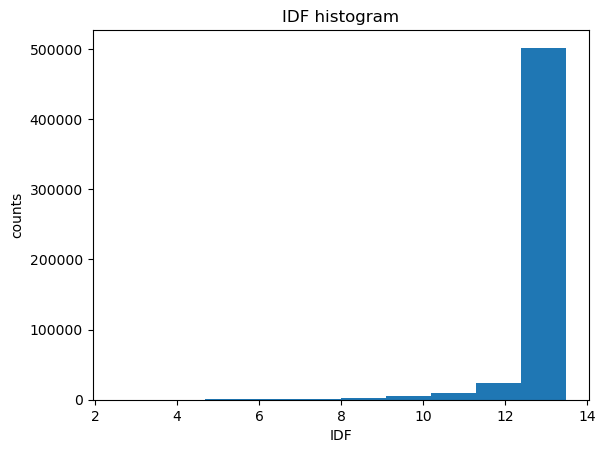

In [17]:
plt.hist(idf_dict.values())
plt.xlabel('IDF')
plt.ylabel('counts')
plt.title('IDF histogram')

In [18]:
print(f'Слова, которые встречаются в документе всего один раз имеют IDF = {np.log(len(corpus))}')

Слова, которые встречаются в документе всего один раз имеют IDF = 13.178066733160517


In [41]:
keys_to_del = []

for key in idf_dict.keys():
    if idf_dict[key] > 13:
        keys_to_del.append(key)

for key in keys_to_del:
    idf_dict.pop(key)

In [42]:
print(f'Получили вектора длины: {len(idf_dict)}')

Получили вектора длины: 86779


Удалим такие слова, которые встречаются всего один раз, так как, скорее всего, это просто мусор или опечатки

Создадим экземпляр класса Tf_idf_vectorizer:

In [43]:
from vector_space_models_utils import Tf_idf_vectorizer

In [44]:
our_tf_idf_vectorizer = Tf_idf_vectorizer(idf_dict, tokenizer_with_stemming)

Оценим качество модели, так как подсчёт tf и операции с векторами большой размерности занимают много времени, будем использовать каждый 50 пост и его комментарии:

In [ ]:
from vector_space_models_utils import get_ndcg_of_whole_dataset

In [53]:
tf_idf_ndcg =  get_ndcg_of_whole_dataset(train_df[::50].reset_index(), our_tf_idf_vectorizer)
print(f'Tf-IDF NDCG@5: {tf_idf_ndcg}')

Tf-IDF NDCG@5: 0.7866337545937307


На меньшей части обучающей выборки получили NDCG@50 = 0.787, что меньше, чем у подхода на embedding. Важно отметить, что в Tf-IDF вектора имеют существенно большую размерность и операции с ними происходят значительно дольше.

# BERT model

В данном разделе будем получать вектор предложения из латентных слоёв модели BERT:

In [10]:
from transformers import BertTokenizer, BertModel

In [12]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
bert_model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

Создадим экземпляр класса BERT_vectorizer:

In [13]:
from vector_space_models_utils import BERT_vectorizer

In [14]:
bert_vectorizer = BERT_vectorizer(bert_model, bert_tokenizer)

Оценим качество модели:

In [18]:
predicted_ranks = [rank_comments(post_text, comments_text, bert_vectorizer)]
print(f'predicted ranks: {predicted_ranks}')
true_ranks = [[0, 1, 2, 3, 4]]

print(f'NDCG@5: {ndcg_score(true_ranks, predicted_ranks, k=5)}')

predicted ranks: [[2, 4, 0, 3, 1]]
NDCG@5: 0.7358812399521907
